In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import numpy as np
import glob, os
from scipy.stats import iqr
import soundfile as sf

In [ ]:
load_model = True

In [4]:
def load_stfts(directory_path):

    specs = []
    spec_paths = glob.glob(os.path.join(directory_path, '*.npy'))
    specs += [np.load(path) for path in spec_paths]

    return specs

def normalize(data, type = 'standardization'):
    if type == 'standardization':
        return np.array([(x - x.mean()) / x.std() for x in data])
    if type == 'minmax':
        return np.array([(x - x.min()) / (x.max() - x.min()) for x in data])
    if type == 'robust':
        return np.array([(x - np.median(x)) / iqr(x) for x in data])
    if type == 'max':
        return np.array([x / np.max(np.abs(x)) for x in data])
    
def build_generator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    z = tf.keras.layers.BatchNormalization()(input_layer)
    z = tf.keras.layers.Dense(64 * 29 * 1, use_bias = False)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Reshape(target_shape = (64, 29, 1))(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (2, 7), strides = (2, 1), use_bias = False)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (2, 7), strides = (2, 1), use_bias = False)(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (2, 7), strides = (2, 2), padding = 'valid', use_bias = False, activation='relu')(z)
    return tf.keras.Model(input_layer, z, name = 'generator')

def build_discriminator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(input_layer)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (3, 2), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (3, 3), use_bias = True, padding = 'valid')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, use_bias = True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(1, use_bias = True, activity_regularizer=tf.keras.regularizers.L1(0.1))(x)
    return tf.keras.Model(input_layer, x, name = 'discriminator')

In [5]:
batch_size = 16

generator_input_shape = (batch_size, 512, )
discriminator_input_shape = (batch_size, 512, 87, 1)

generator = build_generator(generator_input_shape)
discriminator = build_discriminator(discriminator_input_shape)

In [7]:
from sklearn.model_selection import train_test_split

directory_path = "C:/Users/damia/AudioMNIST-recon/data/"

stfts = load_stfts(directory_path)

X_train, X_test, _, _ = train_test_split(stfts, np.random.rand(stfts[0].shape[0],), random_state= 12, shuffle = True, test_size = 0.25)
X_train, train_min, train_max = normalize(X_train.reshape(*X_train.shape, 1), type = 'minmax')
X_test, test_min, test_max = normalize(X_test.reshape(*X_test.shape, 1), type = 'minmax')

IndexError: list index out of range

In [5]:
import gan
gan_model = gan.GAN(generator=generator, discriminator=discriminator)
gan_model.compile()

In [ ]:
gan_model.fit(X_train, batch_size = batch_size, epochs = 10, shuffle = True)

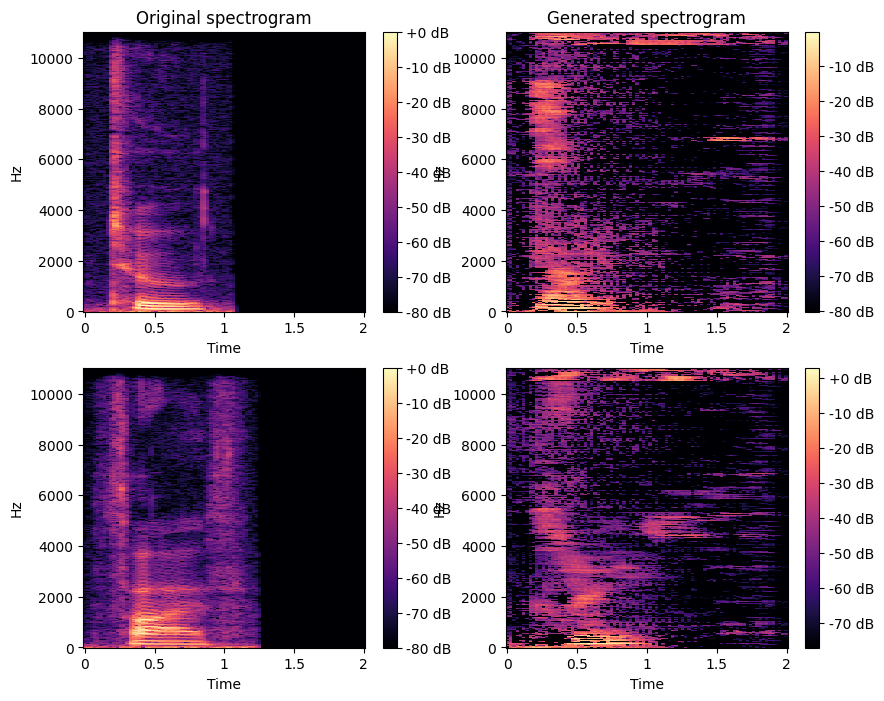

In [11]:
noise = tf.random.normal(shape = generator_input_shape)
generated = gan_model.generator(noise)
n = 2
fig, ax = plt.subplots(n, 2, figsize = (10, 4 * n))
ax[0][0].set(title = "Original spectrogram")
ax[0][1].set(title = "Generated spectrogram")

for i in range(n):
    img_original = librosa.display.specshow(librosa.amplitude_to_db((X_test[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i][0])
    img_recon = librosa.display.specshow(librosa.amplitude_to_db(np.array(generated[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i][1])
    fig.colorbar(img_original, ax = ax[i][0], format = "%+2.f dB", cmap = 'viridis')
    fig.colorbar(img_recon, ax = ax[i][1], format = "%+2.f dB")

In [6]:
if load_model:
    gan_model.generator.load_weights(filepath = "C:/Users/damia/test_audio/gen.keras")
    gan_model.discriminator.load_weights(filepath = "C:/Users/damia/test_audio/disc.keras")

In [36]:
tf.random.set_seed(1234567)
noise = tf.random.normal(shape = generator_input_shape)
generated = gan_model.generator(noise)
sf.write("C:/Users/damia/test_audio/audio_generated.wav", librosa.util.normalize(librosa.griffinlim(np.array(generated[2, :, :, 0]))), samplerate=22050)

In [ ]:
#gan_model.generator.save("C:/Users/damia/test_audio/generator_hq.keras")
#gan_model.discriminator.save("C:/Users/damia/test_audio/discriminator_hq.keras")